# Notebook for OPF Prediction with RGNN on CPU

### Create PyGT Graph Data Sets

#### Helper Functions

In [ ]:
import torch
import pandas as pd
import numpy as np

# Read busses and edges
busses = pd.read_excel('Busses_Timeseries_Table_2022.xlsx')
edges = pd.read_excel('Edges_Timeseries_Table_2022.xlsx')

#Functions to create graph from (busses, edges)-sample
def sourceNodes(timestamp):
    source = edges.loc[edges['datetime_beginning_utc'] == timestamp, 'From Number']
    target = edges.loc[edges['datetime_beginning_utc'] == timestamp, 'To Number']
    sourceNp = pd.concat([source, target])
    targetNp = pd.concat([target, source])
    return (sourceNp, targetNp)
    
def nodeAttributes(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['mw_norm', 'incremental_price', 'inter_start_cost', 'min_ecomin', 'max_ecomax']]
    return attributes.to_numpy()

# Approach to only use capacity, mostly used    
def edgeAttributes(timestamp):
    attributes = edges.loc[edges['datetime_beginning_utc'] == timestamp, ['X', 'Lim MVA A']]
    weights = attributes['Lim MVA A'] # The models can not handle multiple edge features -> choose or connect
    attributes2 = pd.concat([weights, weights], axis=0).to_numpy()
    return attributes2

# Approach to integrate reactance and capactiy  
def edgeAttributesConnected(timestamp):
    attributes = edges.loc[edges['datetime_beginning_utc'] == timestamp, ['X', 'Lim MVA A']]
    sumLimit = sum(attributes['Lim MVA A'])
    weights = attributes['X'] * attributes['Lim MVA A'] / sumLimit # Use aggregation with weighting of capacity
    attributes2 = pd.concat([weights, weights], axis=0).to_numpy()
    return attributes2

def solAttributes(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['solTheta', 'solGenerate']]
    return attributes.to_numpy()

# To only test for generation prediction
def solAttributesT1(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['solTheta']]
    return attributes.to_numpy()    


#### Create Snapshots

In [ ]:
# Temporal data snapshots are PyTorch Geometric data object for each snapshot
# Iterated by DynamicGraphTemporalSignal

import torch_geometric_temporal
from torch_geometric_temporal.signal.dynamic_graph_temporal_signal import DynamicGraphTemporalSignal
timestamps = busses['datetime_beginning_utc'].unique()
numGraph = len(timestamps)
edge_indices = list()
features = list()
targets = list()
edge_weights = list()

# Append graphs per time
timeInterval = 0
for timeInterval in range(numGraph):  
    timestamp = pd.Timestamp(timestamps[timeInterval])
    source, target = sourceNodes(timestamp)
    edge_index = np.array([source, target], dtype=np.float32)
    x = np.array(nodeAttributes(timestamp), dtype=np.float32)
    y  = np.array(solAttributes(timestamp), dtype=np.float32)
    edge_attr = np.array(edgeAttributes(timestamp), dtype=np.float32)
    edge_indices.append(edge_index)
    features.append(x)
    targets.append(y)
    edge_weights.append(edge_attr)
    
dataset = DynamicGraphTemporalSignal(edge_indices, edge_weights, features, targets)

#### Split

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
# A split of dataset taking DynamicSignal object, later snapshots contribute to test set, splits along ratio
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

### Create PyGT Model (on CPU)

#### Complexity Level 2

In [ ]:
# (Dynamic Convolutional) Recurrent Graph Neural Network
# Complexity Level 2 with Normalization and Dropout
# DCRNN layer & feedforward network
import torch.nn.functional as F
from torch_geometric.nn.norm import BatchNorm 
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.bn = BatchNorm(node_features)
        self.recurrent = DCRNN(node_features, filters, 2) 
        #Arguments: In, Out (hyper-param, many for Complexity), K (#neighbors/steps, take 2)
        self.linear1 = torch.nn.Linear(filters, 20)
        self.linear2 = torch.nn.Linear(20, 2) # 2 Outputs

    def forward(self, x, edge_index, edge_weight):
        x = self.bn(x) # Normalization layer
        h = self.recurrent(x, edge_index, edge_weight) #DCRNN: GCNN + GRU
        h = F.dropout(h, training=self.training) # Dropout against Overfitting
        h = F.relu(h) # Non-Linearity
        h = self.linear1(h)
        h = self.linear2(h) # Compute Regression Output
        return h

#### Complexity Level 3

In [31]:
# Multiple DCRNN layers
import torch.nn.functional as F
from torch_geometric.nn.norm import BatchNorm 
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        #self.bn1 = torch.nn.BatchNorm1d(node_features) #Adding normalization layer
        #self.bn1 = BatchNorm(node_features) #Adding normalization layer
        self.recurrent1 = DCRNN(node_features, filters, 2) # Another temporal layer
        self.recurrent2 = DCRNN(filters, 20, 2)
        self.linear1 = torch.nn.Linear(20, 10)
        self.linear2 = torch.nn.Linear(10, 2)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent1(x, edge_index, edge_weight) 
        h = F.relu(h)
        h = F.dropout(h, training=self.training) 
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h) 
        h = self.linear2(h)
        return h

In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features=5, filters=40)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizer with learining rate
criterion = torch.nn.MSELoss() # MSE as Error Metric

costs = list()
model.train()

for epoch in tqdm(range(100)): # Number of Epochs adaptable
    cost = 0
    costT1 = 0
    costT2 = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + criterion(y_hat, snapshot.y)
    cost = cost / (time+1)
    
    #Track Costs
    costs.append(cost.detach().numpy())
    
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
# Predict and Evaluate Model on Test Set
model.eval()
cost = 0
predictions = list()
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    predictions.append(y_hat)
    cost = cost + criterion(y_hat, snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

### Additional Evaluations

In [57]:
test_dataset.targets

array([[3226.0327 ],
       [1771.8083 ],
       [2889.0173 ],
       [1563.8215 ],
       [1798.8997 ],
       [1247.9696 ],
       [1538.9186 ],
       [ 698.7978 ],
       [1249.2341 ],
       [1160.8326 ],
       [1313.4514 ],
       [1281.6498 ],
       [1262.9355 ],
       [1182.22   ],
       [1055.0587 ],
       [1226.7207 ],
       [1194.6125 ],
       [1020.8108 ],
       [1058.9441 ],
       [1132.4268 ],
       [1015.8745 ],
       [ 900.3083 ],
       [ 831.1064 ],
       [ 695.0012 ],
       [ 482.5822 ],
       [ 481.81903],
       [ 193.46698],
       [ 443.52167],
       [  92.31734],
       [   0.     ],
       [3577.825  ]], dtype=float32)

In [12]:
# Methods to extract Targets and Predictions form Test Set
def extractPred(lst, target):
    t1 = list()
    for item in lst:
        for item2 in item:
            res = item2[target-1].detach().numpy()
            t1.append(item2[target-1].detach().numpy())
    return np.asarray(t1)

def extractTarget(lst, target):
    t1 = list()
    for item in lst:
        for item2 in item:
            t1.append(item2[target-1])
    return np.asarray(t1)


target1 = extractTarget(test_dataset.targets, 1)
target2 = extractTarget(test_dataset.targets, 2)

In [16]:
# Data Checks
print(min(target1))
print(max(target1))
print(np.mean(target1))
print(np.var(target1))

print(min(target2))
print(max(target2))
print(np.mean(target2))
print(np.var(target2))


0.0
5245.421
903.6719
312306.6
0.0
110.25
8.496158
319.73886


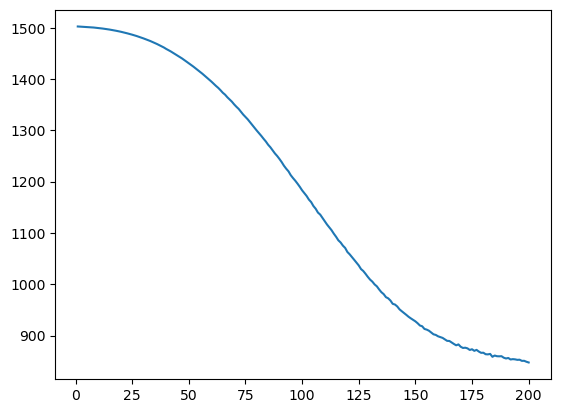

In [58]:
# Example Graph: Plot Training RMSE
import matplotlib.pyplot as plt
import math
def convert(x):
    return math.sqrt(x)

costsD = list(map(convert, costs))
plt.plot(np.linspace(1, 200, 200).astype(int), costsD)